David Lattimer  
2/6/2021  
DSC 550  
# Heart Disease Case Study

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from yellowbrick.features import Rank2D
from yellowbrick.style import set_palette
from yellowbrick.features import ParallelCoordinates
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score
import seaborn as sns
import warnings

In [2]:
#Let's turn off warnings to clean this up a bit
warnings.filterwarnings("ignore")

In [3]:
#Load the data into a DataFrame
df = pd.read_csv('data.csv')

In [4]:
#Lets look at what we have
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,28,1,2,130,132,0,2,185,0,0.0,?,?,?,0
1,29,1,2,120,243,0,0,160,0,0.0,?,?,?,0
2,29,1,2,140,?,0,0,170,0,0.0,?,?,?,0
3,30,0,1,170,237,0,1,170,0,0.0,?,?,6,0
4,31,0,2,100,219,0,1,150,0,0.0,?,?,?,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289,52,1,4,160,331,0,0,94,1,2.5,?,?,?,1
290,54,0,3,130,294,0,1,100,1,0.0,2,?,?,1
291,56,1,4,155,342,1,0,150,1,3.0,2,?,?,1
292,58,0,2,180,393,0,0,110,1,1.0,2,?,7,1


In [5]:
#Lets see what we are working with. And see what needs to be fixed. Some categorical options are currently numerical
df.describe()

,age,sex,cp,oldpeak,num
count,294.000000,294.000000,294.000000,294.000000,294.000000
mean,47.826531,0.724490,2.982993,0.586054,0.360544
std,7.811812,0.447533,0.965117,0.908648,0.480977
min,28.000000,0.000000,1.000000,0.000000,0.000000
25%,42.000000,0.000000,2.000000,0.000000,0.000000
50%,49.000000,1.000000,3.000000,0.000000,0.000000
75%,54.000000,1.000000,4.000000,1.000000,1.000000
max,66.000000,1.000000,4.000000,5.000000,1.000000


In [6]:
# Here are our categorical columns. But they are number. Because we use '?' for missing values 
# we need to make these numerical
df.describe(include='O')

,trestbps,chol,fbs,restecg,thalach,exang,slope,ca,thal
count,294,294,294,294,294,294,294,294,294
unique,32,154,3,4,72,3,4,2,4
top,120,?,0,0,150,0,?,?,?
freq,65,23,266,235,29,204,190,291,266


In [7]:
#When trying to work with df.num I had issues... oh, thats why.
df.columns

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num       '],
      dtype='object')

In [8]:
#Rename the column to remove the whitespace.
df = df.rename(columns={'num       ':'num'})

In [9]:
#Lets make our categorical options categorical and rename the num column. We will have two dataframes to use now
#One with named options (categorical) and one with numeric options (numerical) for when we need them. 
df_cats = df.copy()
df_cats = df_cats.replace({'sex': {1: 'Male', 0: 'Female'}})
df_cats = df_cats.replace({'num': {1: 'Heart Disease', 0:'No Heart Disease'}})
df_cats = df_cats.replace({'cp': {1: 'Typical angina', 2: 'Atypical angina', 3: 'Non-anginal pain', 4:'Asymptomatic'}})
df_cats = df_cats.replace({'fbs': {1: 'Above 120', 0: 'Below 120'}})

In [10]:
#We can look at the numerical data. There should be more but ?s are messing with that. We will fix that 
df_cats.describe()

,age,oldpeak
count,294.000000,294.000000
mean,47.826531,0.586054
std,7.811812,0.908648
min,28.000000,0.000000
25%,42.000000,0.000000
50%,49.000000,0.000000
75%,54.000000,1.000000
max,66.000000,5.000000


In [11]:
#Summary of the categorical data
df_cats.describe(include='O')

,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,slope,ca,thal,num
count,294,294,294,294,294,294,294,294,294,294,294,294
unique,2,4,32,154,3,4,72,3,4,2,4,2
top,Male,Asymptomatic,120,?,0,0,150,0,?,?,?,No Heart Disease
freq,213,123,65,23,266,235,29,204,190,291,266,188


In [12]:
#Lets remove the ?s
df = df.replace({'?': np.NaN})

In [13]:
#Here are the columns with missing values, and how many
df.isnull().sum()

age           0
sex           0
cp            0
trestbps      1
chol         23
fbs           8
restecg       1
thalach       1
exang         1
oldpeak       0
slope       190
ca          291
thal        266
num           0
dtype: int64

In [14]:
#We don't need this, it is all missing values
df.drop('ca', axis=1, inplace=True)

In [15]:
df.fillna(df.median(), inplace=True)

In [16]:
df.trestbps = pd.to_numeric(df.trestbps)
df.chol = pd.to_numeric(df.chol)
df.fbs = pd.to_numeric(df.fbs)
df.restecg = pd.to_numeric(df.restecg)
df.thalach = pd.to_numeric(df.thalach)
df.exang = pd.to_numeric(df.exang)
df.slope = pd.to_numeric(df.slope)
df.thal = pd.to_numeric(df.thal)

In [17]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,thal,num
count,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000
mean,47.826531,0.724490,2.982993,132.574830,250.234694,0.068027,0.217687,139.132653,0.302721,0.586054,1.962585,5.965986,0.360544
std,7.811812,0.447533,0.965117,17.597108,64.982245,0.252222,0.460257,23.549514,0.460219,0.908648,0.207277,0.501397,0.480977
min,28.000000,0.000000,1.000000,92.000000,85.000000,0.000000,0.000000,82.000000,0.000000,0.000000,1.000000,3.000000,0.000000
25%,42.000000,0.000000,2.000000,120.000000,211.250000,0.000000,0.000000,122.000000,0.000000,0.000000,2.000000,6.000000,0.000000
50%,49.000000,1.000000,3.000000,130.000000,243.000000,0.000000,0.000000,140.000000,0.000000,0.000000,2.000000,6.000000,0.000000
75%,54.000000,1.000000,4.000000,140.000000,277.000000,0.000000,0.000000,155.000000,1.000000,1.000000,2.000000,6.000000,1.000000
max,66.000000,1.000000,4.000000,200.000000,603.000000,1.000000,2.000000,190.000000,1.000000,5.000000,3.000000,7.000000,1.000000


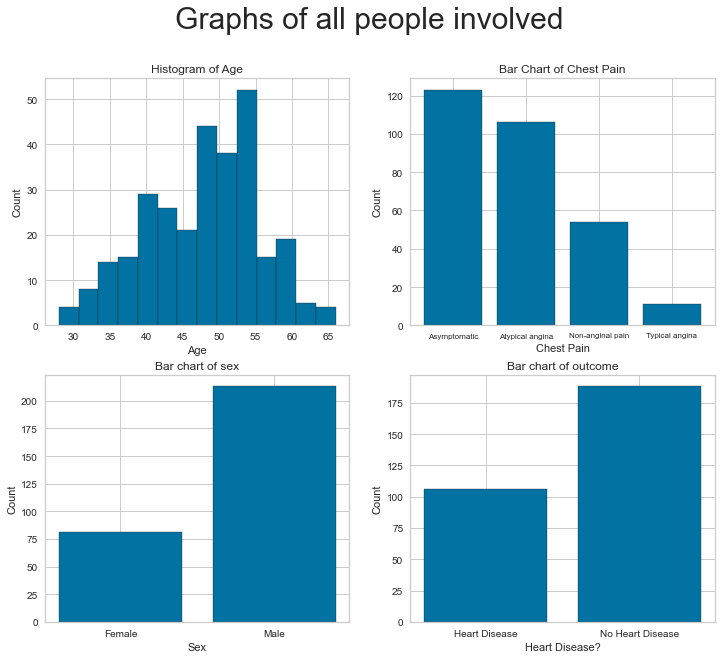

In [18]:
#Setting up the charts. This is for the full group of people.
plt.figure(figsize=(12,10))
plt.suptitle('Graphs of all people involved', fontsize=30)

#Setting up the age histogram
plt.subplot(221)
plt.hist(df_cats.age, edgecolor='k', bins=14, color='b')
plt.title('Histogram of Age')
plt.ylabel('Count')
plt.xlabel('Age')


#Setting up the CP bar chart
plt.subplot(222)
x_cp = df_cats.groupby('cp').size().reset_index(name='Counts')['cp']
y_cp = df_cats.groupby('cp').size().reset_index(name='Counts')['Counts']
plt.bar(x_cp, y_cp, edgecolor='k', color='b')
plt.title('Bar Chart of Chest Pain')
plt.ylabel('Count')
plt.xlabel('Chest Pain')
plt.xticks(fontsize=8)


#Setting up the sex bar chart
plt.subplot(223)
x_sex = df_cats.groupby('sex').size().reset_index(name='Counts')['sex']
y_sex = df_cats.groupby('sex').size().reset_index(name='Counts')['Counts']
plt.bar(x_sex, y_sex, edgecolor='k', color='b')
plt.title('Bar chart of sex')
plt.xlabel('Sex')
plt.ylabel('Count')


#Setting up the num bar chart
plt.subplot(224)
x_num = df_cats.groupby('num').size().reset_index(name='Counts')['num']
y_num = df_cats.groupby('num').size().reset_index(name='Counts')['Counts']
plt.bar(x_num, y_num, edgecolor='k', color='b')
plt.title('Bar chart of outcome')
plt.xlabel('Heart Disease?')
plt.ylabel('Count')


plt.show()

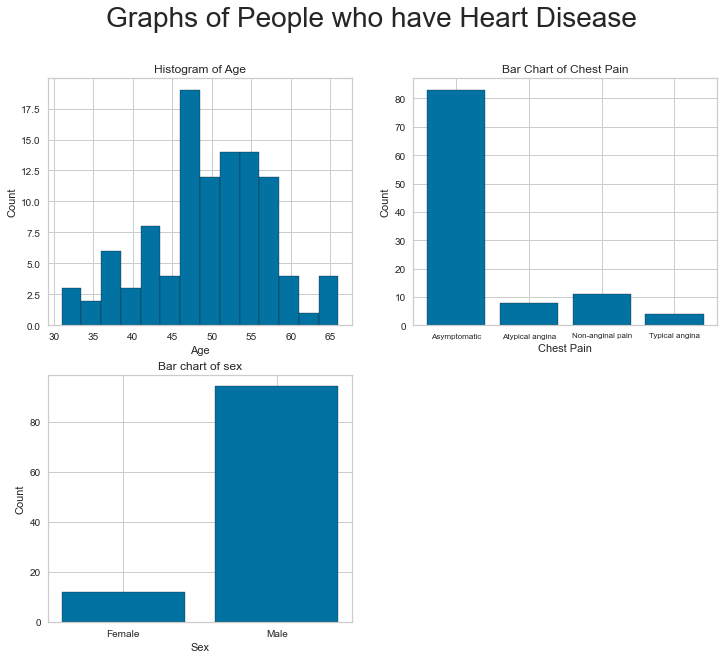

In [19]:
df_hearts = df_cats[df_cats.num == 'Heart Disease']

#Setting up the charts. This is for the full group of people.
plt.figure(figsize=(12,10))
plt.suptitle('Graphs of People who have Heart Disease', fontsize=28)


#Setting up the age histogram
plt.subplot(221)
plt.hist(df_hearts.age, edgecolor='k', bins=14, color='b')
plt.title('Histogram of Age')
plt.ylabel('Count')
plt.xlabel('Age')


#Setting up the CP bar chart
plt.subplot(222)
x_cp = df_hearts.groupby('cp').size().reset_index(name='Counts')['cp']
y_cp = df_hearts.groupby('cp').size().reset_index(name='Counts')['Counts']
plt.bar(x_cp, y_cp, edgecolor='k', color='b')
plt.title('Bar Chart of Chest Pain')
plt.ylabel('Count')
plt.xlabel('Chest Pain')
plt.xticks(fontsize=8)


#Setting up the sex bar chart
plt.subplot(223)
x_sex = df_hearts.groupby('sex').size().reset_index(name='Counts')['sex']
y_sex = df_hearts.groupby('sex').size().reset_index(name='Counts')['Counts']
plt.bar(x_sex, y_sex, edgecolor='k', color='b')
plt.title('Bar chart of sex')
plt.xlabel('Sex')
plt.ylabel('Count')


plt.show()

In [20]:
df.columns

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'thal', 'num'],
      dtype='object')

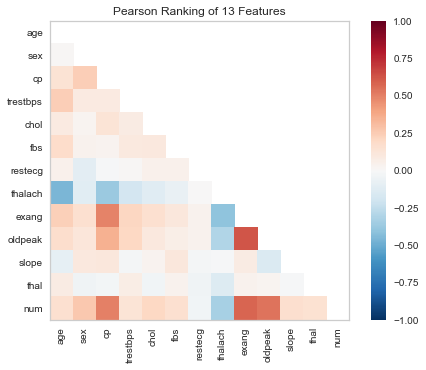

In [21]:
pearsons = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'thal', 'num']
x = df[pearsons].to_numpy()

visualizer = Rank2D(features=pearsons, algorithm='pearson')
visualizer.fit(x)
visualizer.transform(x)
visualizer.show() 

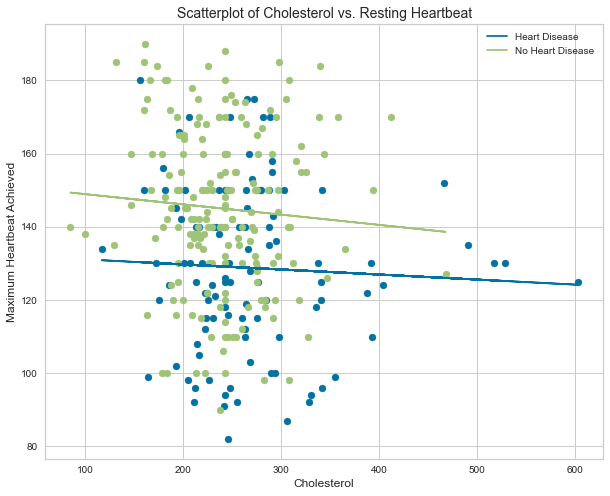

In [22]:
#Graphing a scatter. We only really have 3 numerical values, so we will use the two most influential on num.

# We are going to set some variables now so its a bit easier. Also going to make bet fit lines so we can see trends
# And see a bit of what is happening

x1=df[df.num==1].chol
y1=df[df.num==1].thalach
x2=df[df.num==0].chol
y2=df[df.num==0].thalach
m1, b1 = np.polyfit(x1, y1, 1)
m2, b2 = np.polyfit(x2, y2, 1)


#This sets up the plot. We will graph two scatters and 2 best fit lines. I think I can plot the points and change
#The colors based on heart disease, but this works too

plt.figure(figsize=(10,8))

#Scatter of people with heart disease
plt.scatter(x1,y1, color='b')

#Best fit line of heart disease
plt.plot(x1, m1*x1+b1, color='b')

#Scatter of people without heart disease
plt.scatter(x2, y2, color='g')

#Best fit line of people without heart disease
plt.plot(x2, m2*x2+b2, color='g')

plt.title('Scatterplot of Cholesterol vs. Resting Heartbeat', fontsize=14)
plt.xlabel('Cholesterol', fontsize=12), plt.xticks(fontsize=10)
plt.ylabel('Maximum Heartbeat Achieved', fontsize=12), plt.yticks(fontsize=10)
plt.legend(['Heart Disease', 'No Heart Disease'])
plt.show()

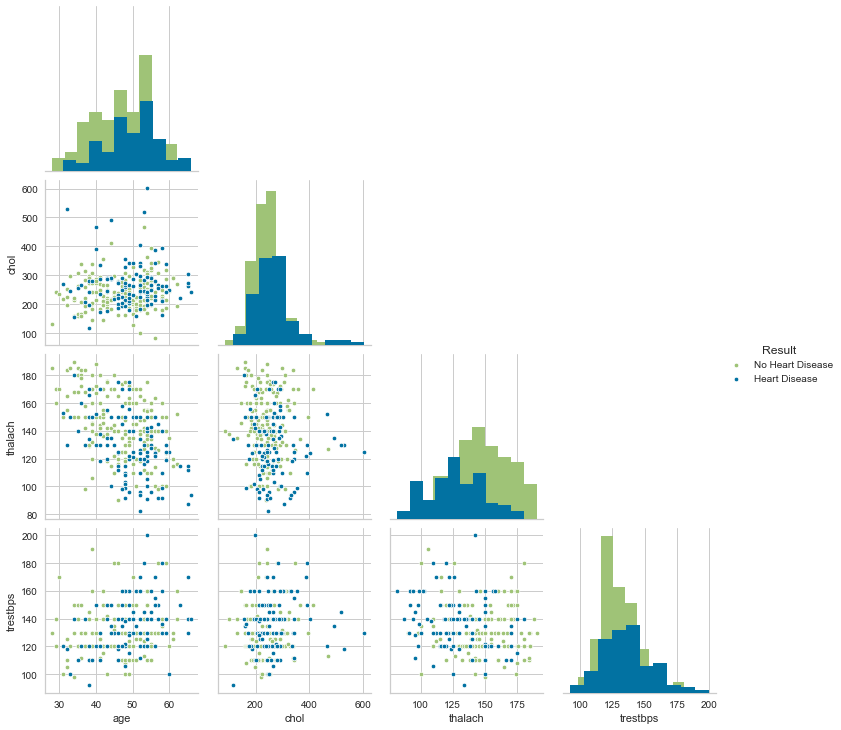

In [23]:
#Let's make a pairplot to show the relationships between all of our numerical values. Makes it easy.

data_heart=df[['age','chol', 'thalach', 'trestbps', 'num']]
data_heart.num = data_heart.num.replace({0:'No Heart Disease', 1: 'Heart Disease'})
data_heart.rename(columns={'num':'Result'}, inplace=True)

sns.pairplot(data_heart, diag_kind='hist', hue='Result', palette=['g','b'] ,corner=True, plot_kws={"s": 21})
plt.show()
warnings.filterwarnings("ignore")

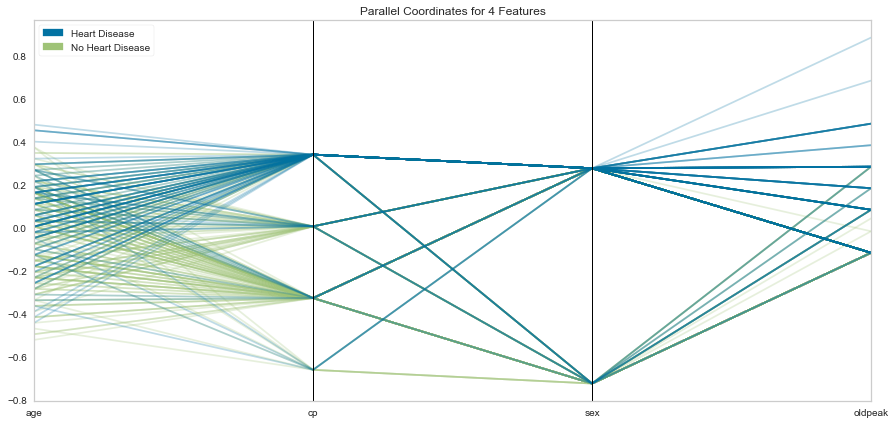

In [24]:
# Use Parallel Coordinates visualization to compare the people that did and didn't have heart attacks.


#Setting up the parallel coordinates details and getting ready to put it in
set_palette(['g','b'])
classes = ['No Heart Disease', 'Heart Disease']
num_features = ['age', 'cp', 'sex', 'oldpeak']

df_norm = df.copy()
for feature in num_features:
    df_norm[feature] = (df[feature] - df[feature].mean(skipna=True)) / (df[feature].max(skipna=True) - df[feature].min(skipna=True))
    
    
    
    
# Putting it in the visualizer  
plt.rcParams['figure.figsize'] = (15, 7)
plt.rcParams['font.size'] = 50
X = df_norm[num_features].to_numpy()
y = df.num.to_numpy()

visualizer = ParallelCoordinates(classes=classes, features=num_features)

visualizer.fit(X, y)      # Fit the data to the visualizer
visualizer.transform(X)   # Transform the data
visualizer.show()
plt.show()


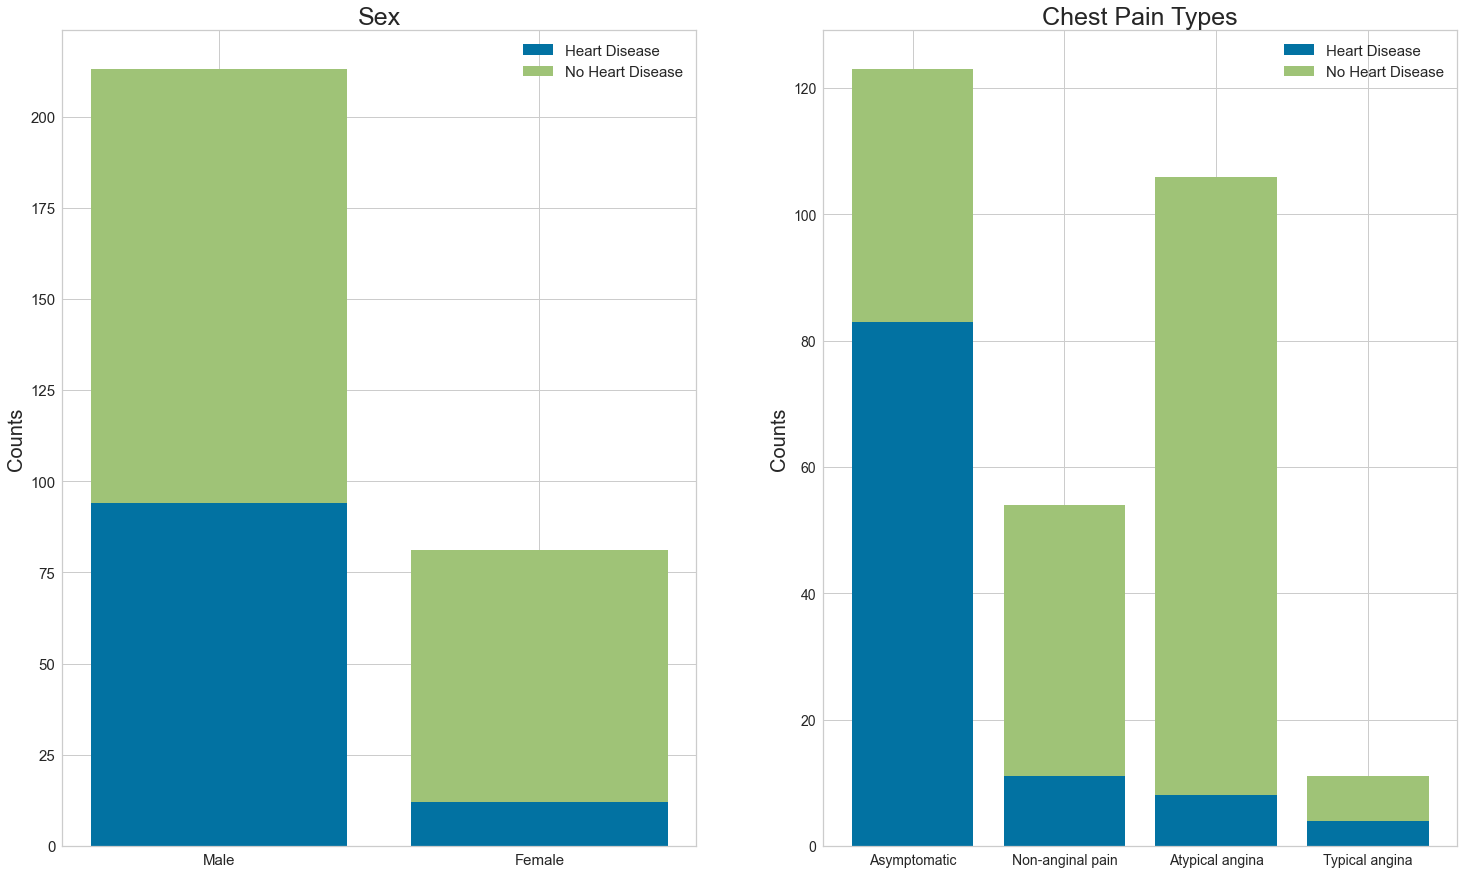

In [50]:
# Use Stack Bar Charts to compare passengers who survived to passengers who didn’t survive based on the other variables.

fig, axes = plt.subplots(nrows = 1, ncols = 2)
plt.rcParams['figure.figsize'] = (22,15)


#Sex and heart attack plot:


# make the data read to feed into the visulizer
Sex_heart = df_cats[df_cats['num']=='Heart Disease']['sex'].value_counts()
Sex_noheart = df_cats[df_cats['num']=='No Heart Disease']['sex'].value_counts()
Sex_noheart = Sex_noheart.reindex(index = Sex_heart.index)

p1 = axes[0].bar(Sex_heart.index, Sex_heart.values, color='b')
p2 = axes[0].bar(Sex_noheart.index, Sex_noheart.values, bottom=Sex_heart.values, color='g')
axes[0].set_title('Sex', fontsize=25)
axes[0].set_ylabel('Counts', fontsize=20)
axes[0].tick_params(axis='both', labelsize=15)
axes[0].legend((p1[0], p2[0]), ('Heart Disease', 'No Heart Disease'), fontsize = 15)


#Making graph of chest pain

# make the data read to feed into the visualizer
cp_heart = df_cats[df_cats['num']=='Heart Disease']['cp'].value_counts()
cp_noheart = df_cats[df_cats['num']=='No Heart Disease']['cp'].value_counts()
cp_noheart = cp_noheart.reindex(index = cp_heart.index)
# make the bar plot
p3 = axes[1].bar(cp_heart.index, cp_heart.values, color='b')
p4 = axes[1].bar(cp_noheart.index, cp_noheart.values, bottom=cp_heart.values, color='g')
axes[1].set_title('Chest Pain Types', fontsize=25)
axes[1].set_ylabel('Counts', fontsize=20)
axes[1].tick_params(axis='both', labelsize=14)
axes[1].legend((p3[0], p4[0]), ('Heart Disease', 'No Heart Disease'), fontsize = 15)
plt.show()

In [26]:
#Lets set up our features and target for model making
features = df.drop('num', axis=1)
target = df.replace({'num': {0:'No Heart Disease', 1:'Heart Disease'}}).num

In [27]:
#And now let's split the data
features_train, features_test, target_train, target_test = train_test_split(features, target, 
                                                                            test_size=0.2, random_state=23)

In [28]:
#Here are how the numbers are split. 20% in the test, 80% in the training.
print("No. of samples in training set: ", features_train.shape[0])
print("No. of samples in validation set:", features_test.shape[0])

No. of samples in training set:  235
No. of samples in validation set: 59


In [29]:
#Look at the numbers we are training with
print('No. of heart disease and no heart disease in the training set:')
print(target_train.value_counts())

No. of heart disease and no heart disease in the training set:
No Heart Disease    153
Heart Disease        82
Name: num, dtype: int64


In [30]:
#Look at how the numbers should come out in the test set
print('No. of heart disease and no heart disease in the test set:')
print(target_test.value_counts())

No. of heart disease and no heart disease in the test set:
No Heart Disease    35
Heart Disease       24
Name: num, dtype: int64


In [31]:
#Load in our model. We will use logistic regression
model = LogisticRegression()

In [32]:
#Now lets fit the model on our training data and then predict the results with that model on the test features
model.fit(features_train, target_train)
target_predicted = model.predict(features_test)

In [33]:
#Now we have the predicted target outcomes in target_predicted, and the actual outcomes in target_test. We can compare them
#In a confusion matrix
matrix = confusion_matrix(target_predicted, target_test)
dataframe = pd.DataFrame(matrix, columns=['Heart Disease', 'No Heart Disease'], index=['Heart Disease', 'No Heart Disease'])

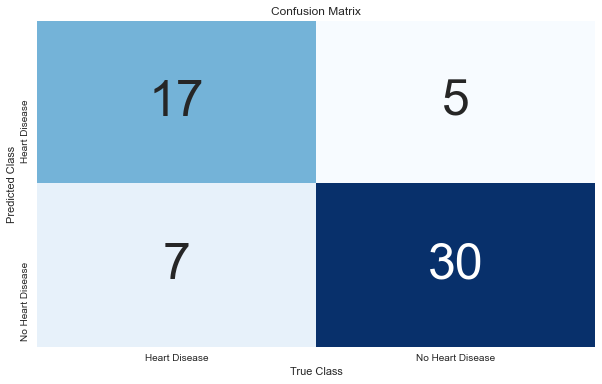

In [34]:
#Graph the confusion matrix

plt.figure(figsize=(10,6))
sns.heatmap(dataframe, annot=True, cbar=None, cmap='Blues', fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('Predicted Class')
plt.xlabel('True Class')
plt.show()

In [35]:
#Print the classification report
print(classification_report(target_predicted, target_test))

                  precision    recall  f1-score   support

   Heart Disease       0.71      0.77      0.74        22
No Heart Disease       0.86      0.81      0.83        37

        accuracy                           0.80        59
       macro avg       0.78      0.79      0.79        59
    weighted avg       0.80      0.80      0.80        59



In [36]:
#Let's set up the ROC curve
logit = LogisticRegression()
logit.fit(features_train, target_train)

LogisticRegression()

In [37]:
#We can find the probabilities and make sure our test is in 0s and 1s.
target_probabilities = logit.predict_proba(features_test)[:,1]
target_test = target_test.replace({'Heart Disease': 1, 'No Heart Disease':0})

In [38]:
#Set the variables we need to graph
false_positive_rate, true_positive_rate, threshold = roc_curve(target_test, target_probabilities)

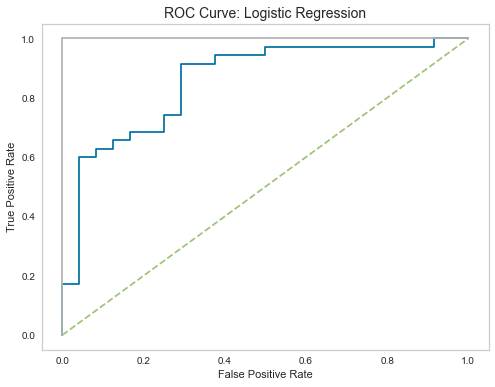

In [39]:
#Plot the ROC Curve
plt.figure(figsize=[8,6])
plt.title('ROC Curve: Logistic Regression', fontsize=14)
plt.plot(true_positive_rate, false_positive_rate, color='b')
plt.grid(b=None)
plt.plot([0,1], ls='--', color='g')
plt.plot([0,0], [1,0], c='.7'), plt.plot([1,1], c='.7')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [40]:
#Now lets split this up and get it ready for a Random Forest Model

X=df[['age', 'sex', 'cp', 'trestbps', 'chol','fbs','restecg','thalach','exang','oldpeak', 'slope', 'thal']] 
y=df['num']

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [41]:
#Import Random Forest Model and set it up.
from sklearn.ensemble import RandomForestClassifier

clf=RandomForestClassifier(n_estimators=100)

In [42]:
#Let's fit the model to the training sets, and then predict the test results with the test data.
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

In [43]:
#Print out the classification report which has precision, recall and f1 score.

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.91      0.87        34
           1       0.86      0.76      0.81        25

    accuracy                           0.85        59
   macro avg       0.85      0.84      0.84        59
weighted avg       0.85      0.85      0.85        59



In [44]:
#Set up the confusion matrix of the Random Forest
matrix2 = confusion_matrix(y_pred, y_test)
dataframe2 = pd.DataFrame(matrix2, columns=['Heart Disease', 'No Heart Disease'], index=['Heart Disease', 'No Heart Disease'])

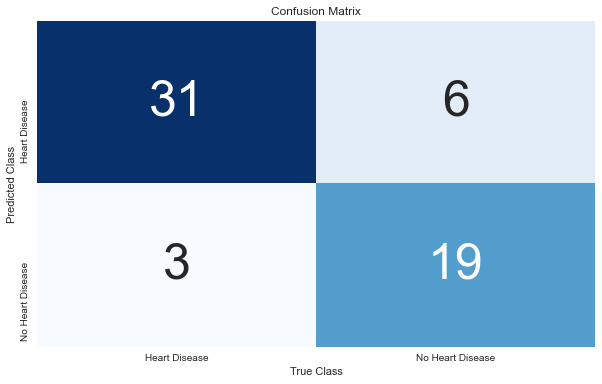

In [45]:
#Graph the confusion matrix

plt.figure(figsize=(10,6))
sns.heatmap(dataframe2, annot=True, cbar=None, cmap='Blues', fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('Predicted Class')
plt.xlabel('True Class')
plt.show()

In [46]:
#Set the variables for the ROC Curve
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_pred)

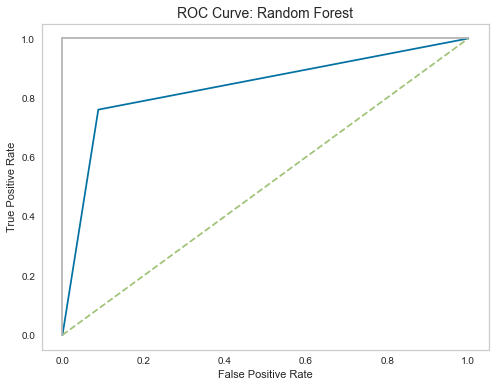

In [47]:
#Plot the ROC Curve of the Random Forest model
plt.figure(figsize=[8,6])
plt.title('ROC Curve: Random Forest', fontsize=14)
plt.plot(false_positive_rate, true_positive_rate, color='b')
plt.grid(b=None)
plt.plot([0,1], ls='--', color='g')
plt.plot([0,0], [1,0], c='.7'), plt.plot([1,1], c='.7')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()